# Overview

In today's competitive business environment, accurate sales forecasting plays a crucial role in the success of any organization. The cinema industry is no exception and can greatly benefit from predictive modeling techniques. Sales forecasting helps cinemas make informed decisions, allocate resources effectively, and manage cash flow efficiently.

This notebook aims to implement sales forecasting for a cinema dataset using both time series and machine learning modeling techniques. By leveraging these methods, we can analyze historical sales data and generate predictions that enable cinemas to make strategic decisions for future growth.

# Contents
* [Importing Libraries and Functions](#0.1)
* [Pre-processing](#0.2)
* [Univariate Analysis](#0.3)
* [Descriptive Time Series](#0.4)
* [Plot a Time Series](#0.5)
* [Check Original Stationarity](#0.6)
* [Differencing](#0.7)
* [Autocorrelation and Partial Autocorrelation](#0.8)
* [Find Best ARIMA](#0.9)
* [ARIMA Result](#0.10)
* [Residual Plot](#0.11)
* [Prediction Plot](#0.12)
* [SARIMAX](#0.13)
* [Machine Learning](#0.14)
* [Concluding Remarks for Model Selection](#0.15)

# Importing Libraries and Functions <a class="anchor" id="0.1"></a>

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.style
import warnings
from IPython.display import display
from matplotlib.pyplot import figure

# Set the style of matplotlib plots to 'fivethirtyeight'
matplotlib.style.use('fivethirtyeight')

# Get the current figure
fig = matplotlib.pyplot.gcf()

import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

# Install pmdarima library
!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from calendar import day_name
from statsmodels.tsa.stattools import adfuller
import warnings


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.2 MB/s eta 0:00:0000:01


<Figure size 432x288 with 0 Axes>

In [2]:
import pandas as pd

def null(df, df_name):
    if df.isnull().values.any() == False:  # Check if there are any null values in the DataFrame
        print(f'STATUS: There are NO null values in {df_name}')
    else:
        print('STATUS: There are null values in the dataframe')
        columns = df.columns[df.isna().any()].tolist()  # Get the columns with null values
        temp = {}
        for column in columns:
            count = len(df) - df[column].count()  # Count the number of null values in each column
            temp[column] = f"{count} ({round((count/len(df)), 4)*100}%)"
        print(f'STATUS: Nulls in {df_name} = {temp} out of total {len(df)}')

def duplicate(df, column):
    if len(df[df[column].duplicated()]) == 0:  # Check if there are any duplicate values in the column
        print(f'STATUS: There are NO duplicate values in the column "{column}"')
    else:
        print(f'STATUS: There are {len(df[df[column].duplicated()])} duplicate values in the column "{column}"')

def shape(df, df_name):
    print(f'STATUS: Dimensions of "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')  # Compute value counts for the column
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)  # Calculate percentage
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)  # Sort by percentage in descending order
    print(f'STATUS: Value counts of "{column}"...')
    display(vc_df)
    if r:
        return vc_df

def pie(df, column):
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', title=f'Pie chart of "{column}"')
    return plt.show()

def drop(df, column):
    df2 = df.drop(column, axis=1)  # Drop the specified column from the DataFrame
    print(f"STATUS: Column(s) {column} were dropped")
    return df2

def dtype(df, column):
    print(f"STATUS: Data type of {column} = {df[column].dtypes}")

def unique(df, column, r=False):
    num = len(df[column].unique())  # Count the number of unique values in the column
    print(f"STATUS: Number of unique values for {column} = {num}")
    if r:
        return num

def move_front(df, column):
    df = df[[column] + [col for col in df.columns if col != column]]  # Move the specified column to the front
    return df

# Set display options
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

# Read dataset
df = pd.read_csv('../input/cinema-ticket/cinemaTicket_Ref.csv')

# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df["date"], errors='coerce')

# Count the number of unique films and cinemas
n_unique_film = df['film_code'].nunique()
n_unique_cinema = df['cinema_code'].nunique()
print(f"Number of unique films = {n_unique_film}")
print(f"Number of unique cinemas = {n_unique_cinema}")

# Check the shape (dimensions) of the DataFrame
shape(df, 'df')

# Count the number of duplicated rows
number_duplicates = len(df[df.duplicated()])
print(f"STATUS: Total duplicated rows = {number_duplicates}")

# Display the first few rows of the DataFrame
df.head()

Number of unique films = 48
Number of unique cinemas = 246
STATUS: Dimensions of "df" = (142524, 14)
STATUS: Total duplicated rows = 106


,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


# Preprocessing Data <a class="anchor" id="0.2"></a>

In [4]:
# Dropping all duplicated rows
df2 = df.drop_duplicates()  # Drop duplicated rows from the DataFrame
print("STATUS: Dropped duplicates")
null(df2, 'df2')  # Check for null values in df2

# Drop columns with null values
df2 = drop(df2, ['occu_perc', 'capacity', 'month', 'quarter', 'day'])  # Drop specified columns from the DataFrame
shape(df2, 'df2')  # Check the shape of df2

# Checking for duplicated dimension columns
duplicate(df2, 'film_code')  # Check for duplicate values in 'film_code' column
duplicate(df2, 'cinema_code')  # Check for duplicate values in 'cinema_code' column

# Solution: Concatenate dimensions to create unique id
cols = ['film_code', 'cinema_code', 'date']
df2['id'] = df2[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)  # Concatenate values from specified columns to create a new 'id' column
df2 = move_front(df2, 'id')  # Move the 'id' column to the front of the DataFrame

# Now each row represents a particular date showing a particular film at a particular cinema
duplicate(df2, 'id')  # Check for duplicate values in 'id' column
display(df2.head())  # Display the first few rows of the DataFrame

# Value counts
vc(df2, 'tickets_out')  # Calculate value counts for 'tickets_out' column
vc(df2, 'film_code')  # Calculate value counts for 'film_code' column
df2.info()  # Display the summary information of df2


STATUS: Dropped duplicates
STATUS: There are null values in the dataframe
STATUS: Nulls in df2 = {'occu_perc': '123 (0.09%)', 'capacity': '123 (0.09%)'} out of total 142418
STATUS: Column(s) ['occu_perc', 'capacity', 'month', 'quarter', 'day'] were dropped
STATUS: Dimensions of "df2" = (142418, 9)
STATUS: There are 142370 duplicate values in the column "film_code"
STATUS: There are 142172 duplicate values in the column "cinema_code"
STATUS: There are NO duplicate values in the column "id"


,id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,ticket_price,ticket_use,date
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,150000.0,26,2018-05-05
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,80000.0,42,2018-05-05
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,80000.0,32,2018-05-05
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,100000.0,12,2018-05-05
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,80000.0,15,2018-05-05


STATUS: Value counts of "tickets_out"...


,count,percentage (%)
tickets_out,,
0,136297,95.702088
2,1613,1.132582
1,1491,1.046918
3,761,0.534343
4,604,0.424104
...,...,...
86,1,0.000702
87,1,0.000702
91,1,0.000702


STATUS: Value counts of "film_code"...


,count,percentage (%)
film_code,,
1554,11614,8.154868
1493,10491,7.366344
1481,9531,6.692272
1484,8551,6.004157
1482,7397,5.193866
1556,7000,4.915109
1483,6972,4.895449
1485,6096,4.280358
1494,6022,4.228398


<class 'pandas.core.frame.DataFrame'>
Int64Index: 142418 entries, 0 to 142523
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            142418 non-null  object        
 1   film_code     142418 non-null  int64         
 2   cinema_code   142418 non-null  int64         
 3   total_sales   142418 non-null  int64         
 4   tickets_sold  142418 non-null  int64         
 5   tickets_out   142418 non-null  int64         
 6   show_time     142418 non-null  int64         
 7   ticket_price  142418 non-null  float64       
 8   ticket_use    142418 non-null  int64         
 9   date          142418 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 12.0+ MB


In [5]:
# Count the number of unique films and cinemas
n_unique_film = df2['film_code'].nunique()  # Count the number of unique films in the 'film_code' column
n_unique_cinema = df2['cinema_code'].nunique()  # Count the number of unique cinemas in the 'cinema_code' column

# Print the number of unique films and cinemas
print(f"Number of unique films = {n_unique_film}")
print(f"Number of unique cinemas = {n_unique_cinema}")

Number of unique films = 48
Number of unique cinemas = 246


# Univariate Analysis <a class="anchor" id="0.3"></a>

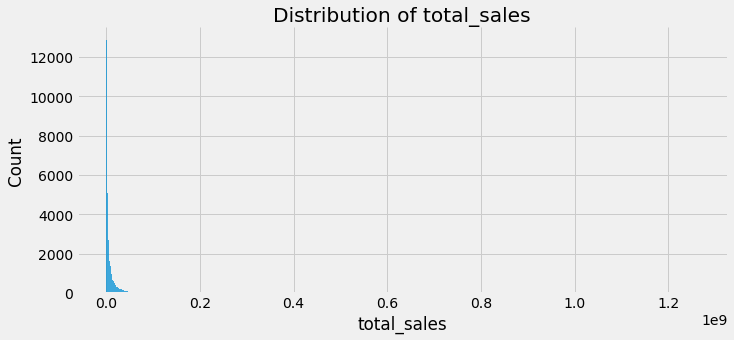

In [6]:
def vis_dist(df, col, lim=False):
    variable = df[col].values  # Extract the values of the specified column from the DataFrame
    ax = sns.displot(variable)  # Create a distribution plot using seaborn
    fig = matplotlib.pyplot.gcf()  # Get the current figure
    fig.set_size_inches(12.5, 4.5)  # Set the size of the figure
    plt.title(f'Distribution of {col}')  # Set the title of the plot
    plt.xlabel(f'{col}')  # Set the x-axis label
    if lim:
        plt.xlim(0, 4000)  # Set the x-axis limits if 'lim' is True
    return plt.show()  # Display the plot

vis_dist(df2, 'total_sales', lim=False)

STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0, 100000000]",139884,98.221420
"(100000000, 200000000]",1931,1.355877
"(200000000, 300000000]",350,0.245757
"(300000000, 400000000]",126,0.088473
"(400000000, 500000000]",57,0.040023
"(600000000, 700000000]",29,0.020363
"(500000000, 600000000]",28,0.019661
"(700000000, 800000000]",4,0.002809
"(800000000, 900000000]",3,0.002106


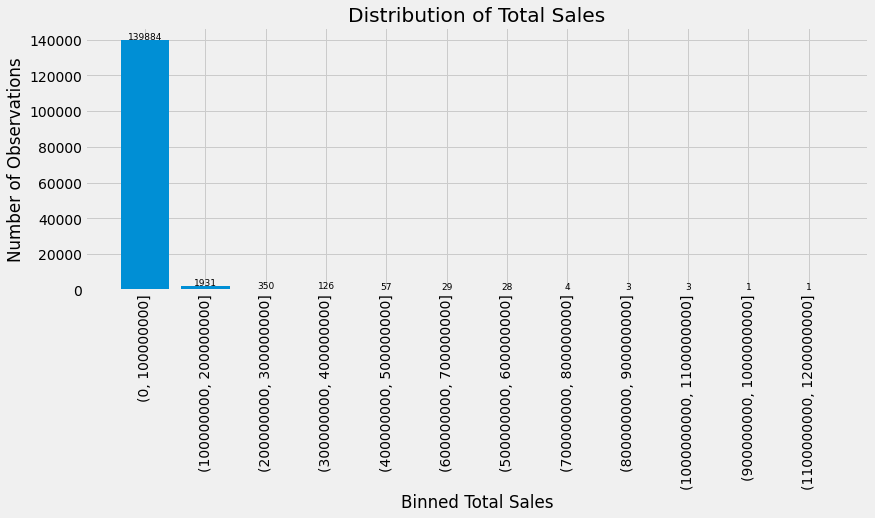

In [7]:
df_uni = df2.copy()  # Create a copy of the DataFrame df2
bins = np.arange(0, 1300000000, 100000000)  # Define the bin boundaries for the total sales
df_uni['binned'] = pd.cut(df2['total_sales'], bins)  # Create a new column 'binned' by binning the total_sales

# Calculate the value counts of 'binned' column
v_count = vc(df_uni, 'binned', r=True)

# Reset the index of the value counts DataFrame
v_count = v_count.reset_index()

# Convert the 'binned' column to string type
v_count['binned'] = v_count['binned'].astype("str")

# Get the values of the 'binned' column and the corresponding counts
x_value = v_count['binned'].values
y_value = v_count['count'].values

# Create a bar plot of the binned total sales
plt.bar(x_value, y_value)
plt.ylabel('Number of Observations')
plt.xlabel('Binned Total Sales')
plt.title(f'Distribution of Total Sales')
plt.xticks(rotation=90)

# Add annotations to the bars with the count values
for x, y in zip(x_value, y_value):
    label = "{:.1%}".format(y)
    plt.annotate(int(y), (x, y), textcoords="offset points", xytext=(0, 1), ha='center', fontsize=9)

# Set the size of the figure
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)

# Display the plot
plt.show()


In [8]:
# Select the first quantile (25th percentile)
q1 = df2['total_sales'].quantile(.25)
print(f"q1 = {q1}")

# Select the third quantile (75th percentile)
q3 = df2['total_sales'].quantile(.75)
print(f"q3 = {q3}")

# Calculate the interquartile range (IQR)
iqr = q3 - q1
print(f"iqr = {iqr}")

# Calculate the value of S (outlier threshold)
S = 1.5 * iqr
print(f"S = {S}")

# Calculate the upper bound and lower bound for valid range
UB = q3 + S
LB = q1 - S
print(f"valid range : {LB} <= total sales <= {UB}")

df_uni = df2.copy()  # Create a copy of the DataFrame df2
bins = np.arange(0, 1300000000, UB)  # Define the bin boundaries using UB
df_uni['binned'] = pd.cut(df2['total_sales'], bins)  # Create a new column 'binned' by binning the total_sales

# Calculate the value counts of 'binned' column
v_count = vc(df_uni, 'binned', r=True)

# Display the value counts
display(v_count)

q1 = 1260000.0
q3 = 11100000.0
iqr = 9840000.0
S = 14760000.0
valid range : -13500000.0 <= total sales <= 25860000.0
STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0.0, 25860000.0]",126416,88.764061
"(25860000.0, 51720000.0]",9192,6.454240
"(51720000.0, 77580000.0]",3010,2.113497
"(77580000.0, 103440000.0]",1415,0.993554
"(103440000.0, 129300000.0]",850,0.596835
"(129300000.0, 155160000.0]",514,0.360909
"(155160000.0, 181020000.0]",282,0.198009
"(181020000.0, 206880000.0]",190,0.133410
"(206880000.0, 232740000.0]",124,0.087068


,count,percentage (%)
binned,,
"(0.0, 25860000.0]",126416,88.764061
"(25860000.0, 51720000.0]",9192,6.454240
"(51720000.0, 77580000.0]",3010,2.113497
"(77580000.0, 103440000.0]",1415,0.993554
"(103440000.0, 129300000.0]",850,0.596835
"(129300000.0, 155160000.0]",514,0.360909
"(155160000.0, 181020000.0]",282,0.198009
"(181020000.0, 206880000.0]",190,0.133410
"(206880000.0, 232740000.0]",124,0.087068


In [9]:
# Calculate the mean and standard deviation of the 'total_sales' column
mean = df2['total_sales'].mean()
print(f"mean = {mean}")
std = df2['total_sales'].std()
print(f"std = {std}")

# Check if the standard deviation is higher than the mean
if std > mean:
    print(f"standard deviation is {std/mean} times higher than mean")

# Define a function to calculate the valid range based on the empirical rule
def empirical_rule(n=1, r=False):
    UB = mean + (n * std)
    LB = mean - (n * std)
    if r:
        return UB
    print(f"valid range of {n} std : {LB} <= total sales <= {UB}")

# Apply the empirical rule for different number of standard deviations
empirical_rule(n=1)
empirical_rule(n=2)
empirical_rule(n=3)

df_uni = df2.copy()  # Create a copy of the DataFrame df2
UB = empirical_rule(n=3, r=True)  # Get the upper bound for 3 standard deviations
bins = np.arange(0, 1300000000, UB)  # Define the bin boundaries using UB
df_uni['binned'] = pd.cut(df2['total_sales'], bins)  # Create a new column 'binned' by binning the total_sales

# Calculate the value counts of 'binned' column
v_count = vc(df_uni, 'binned', r=True)

# Filter the values that are less than or equal to the upper bound
df3 = df2[df2['total_sales'] <= UB]
print(f"STATUS: filtered total sales values <= {UB}")
print(f"STATUS: filtered values with {df2['total_sales'].max()/df3['total_sales'].max()} times higher than current max")

# Recalculate the mean and standard deviation for the filtered data
mean = df3['total_sales'].mean()
print(f"mean = {mean}")
std = df3['total_sales'].std()
print(f"std  = {std}")

mean = 12335890.338222697
std = 30637687.06613741
standard deviation is 2.483621872934999 times higher than mean
valid range of 1 std : -18301796.727914713 <= total sales <= 42973577.40436011
valid range of 2 std : -48939483.794052124 <= total sales <= 73611264.47049752
valid range of 3 std : -79577170.86018954 <= total sales <= 104248951.53663494
STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0.0, 104248951.537]",140064,98.347810
"(104248951.537, 208497903.073]",1817,1.275831
"(208497903.073, 312746854.61]",313,0.219777
"(312746854.61, 416995806.147]",117,0.082153
"(416995806.147, 521244757.683]",44,0.030895
"(521244757.683, 625493709.22]",26,0.018256
"(625493709.22, 729742660.756]",26,0.018256
"(833991612.293, 938240563.83]",4,0.002809
"(729742660.756, 833991612.293]",2,0.001404


STATUS: filtered total sales values <= 104248951.53663494
STATUS: filtered values with 12.120356982435935 times higher than current max
mean = 9424864.694232637
std  = 14975999.135755343


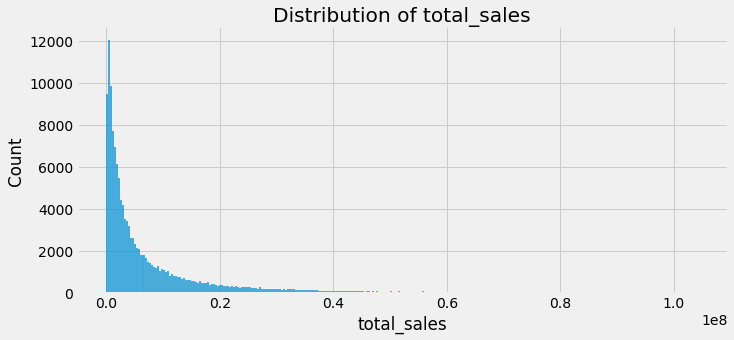

In [10]:
# Visualize the distribution of 'total_sales' in the filtered DataFrame df3
vis_dist(df3, 'total_sales', lim=False)


STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0, 10000000]",103682,74.119985
"(10000000, 20000000]",17729,12.674073
"(20000000, 30000000]",7541,5.390895
"(30000000, 40000000]",3999,2.858797
"(40000000, 50000000]",2341,1.673529
"(50000000, 60000000]",1602,1.145235
"(60000000, 70000000]",1089,0.778502
"(70000000, 80000000]",804,0.574762
"(80000000, 90000000]",626,0.447514


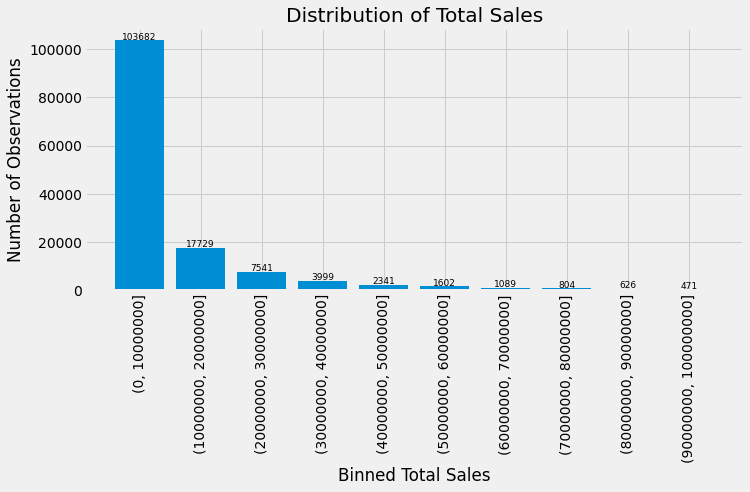

In [11]:
# Create a copy of the filtered DataFrame df3
df_uni = df3.copy()

# Define the bin ranges for creating bins
bins = np.arange(0, 104248951, 10000000)

# Create a new column 'binned' in df_uni to store the binned values of 'total_sales'
df_uni['binned'] = pd.cut(df3['total_sales'], bins)

# Calculate the value counts of each bin in the 'binned' column
v_count = vc(df_uni, 'binned', r=True)

# Reset the index of the value counts DataFrame
v_count = v_count.reset_index()

# Convert the 'binned' column to string type for better display
v_count['binned'] = v_count['binned'].astype("str")

# Extract the x and y values for plotting the bar chart
x_value = v_count['binned'].values
y_value = v_count['count'].values

# Create a bar chart to visualize the distribution of total sales in different bins
plt.bar(x_value, y_value)
plt.ylabel('Number of Observations')
plt.xlabel('Binned Total Sales')
plt.title('Distribution of Total Sales')
plt.xticks(rotation=90)

# Add labels to each bar in the chart
for x, y in zip(x_value, y_value):
    label = "{:.1%}".format(y)
    plt.annotate(int(y), (x, y), textcoords="offset points", xytext=(0, 1), ha='center', fontsize=9)

# Set the size of the figure
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 4.5)

# Display the bar chart
plt.show()


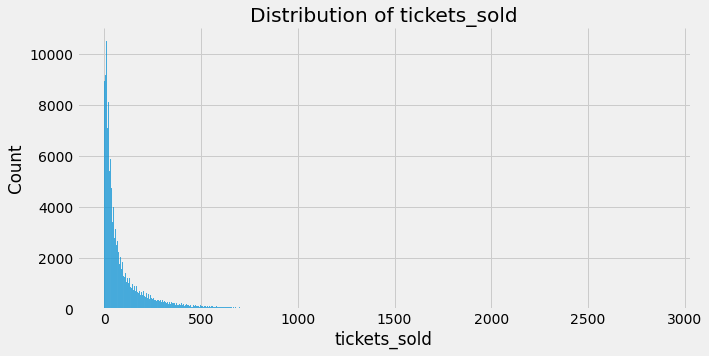

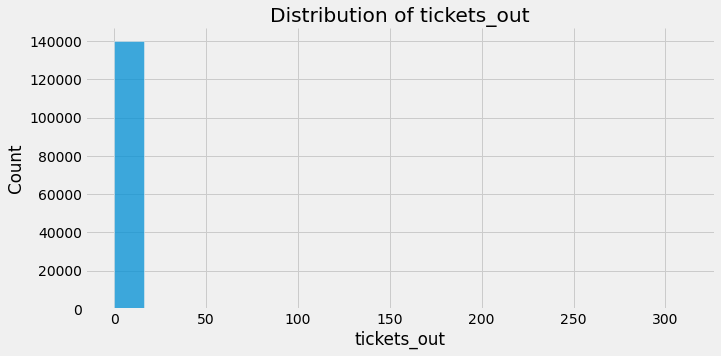

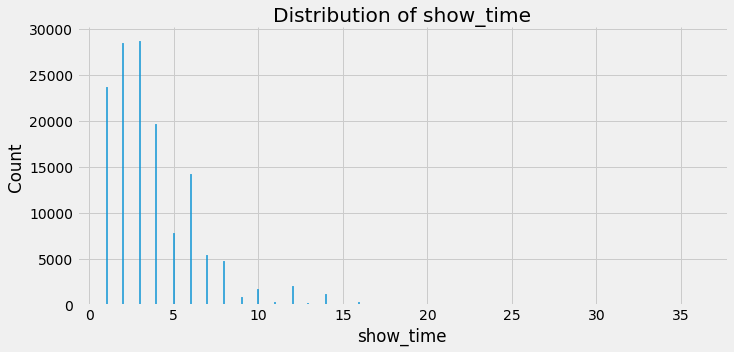

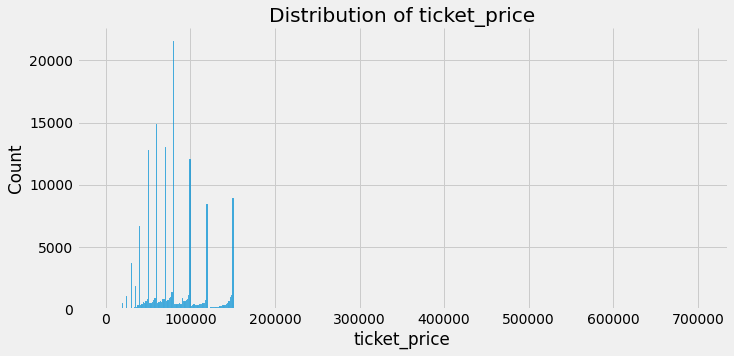

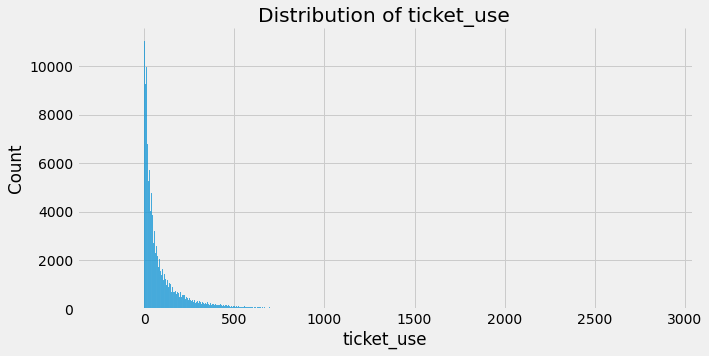

In [12]:
# Define the columns for visualization
columns = ['tickets_sold', 'tickets_out', 'show_time', 'ticket_price', 'ticket_use']

# Iterate over each column and visualize its distribution
for col in columns:
    # Call the 'vis_dist' function to plot the distribution of the column
    vis_dist(df3, col, lim=False)

# Descriptive Time Series <a class="anchor" id="0.4"></a>

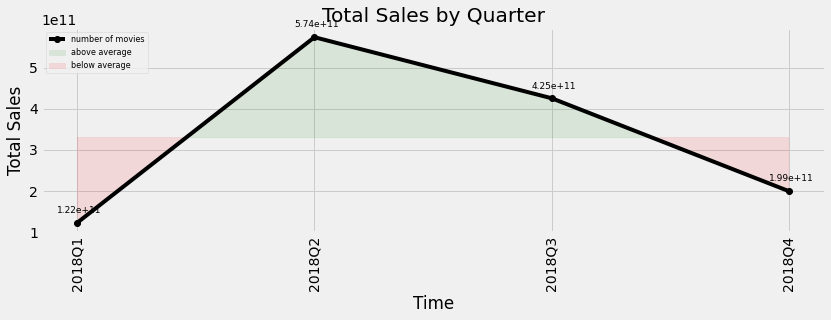

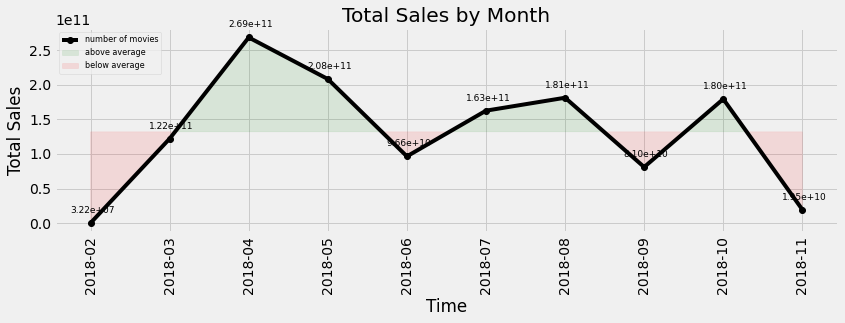

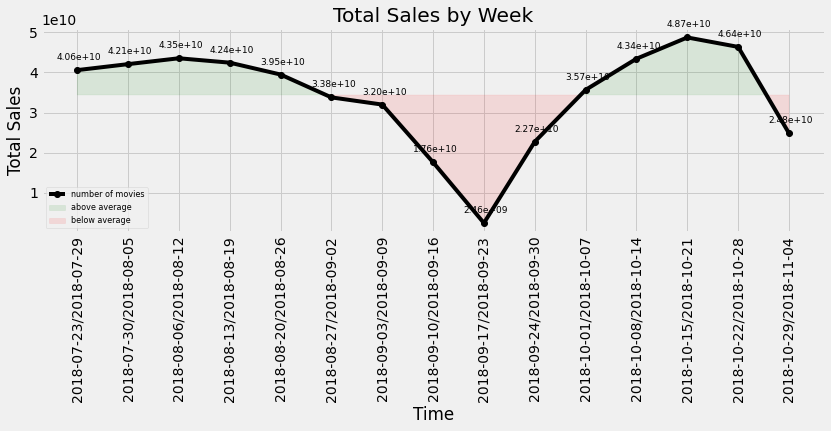

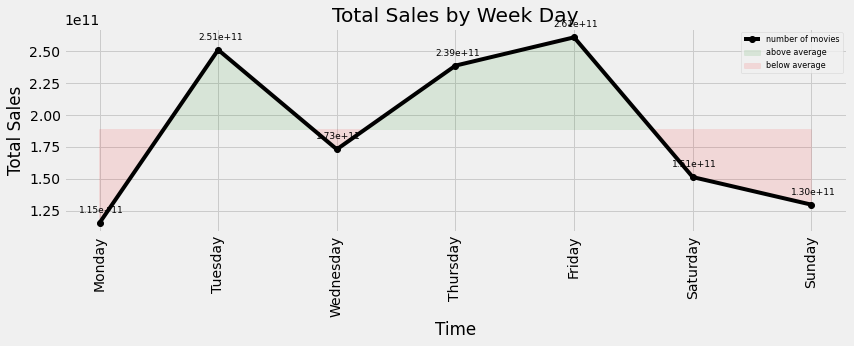

In [13]:
# Function to aggregate data by a specified time period
def aggregate_period(df, period, want_mean, column): 
    # Convert date column to the specified period
    per = df.date.dt.to_period(period)
    if want_mean == False:
        # Aggregate total sales by sum if want_mean is False
        g = df.groupby(per).agg({'total_sales': ['sum']})
        g.columns = ['metric']
    else:
        # Aggregate the specified column by mean if want_mean is True
        g = df.groupby(per).agg({column: ['mean']})
        g.columns = [f'metric']
    g.reset_index(level=0, inplace=True)
    g.date = g.date.astype(str)
    return g

# Function to aggregate data by weekday
def aggregate_period_weekday(df, want_mean, column): 
    # Group data by weekday
    per = df['date'].dt.day_name()
    if want_mean == False:
        # Aggregate total sales by sum if want_mean is False
        g = df.groupby(per).agg({'total_sales': ['sum']})
        g.columns = ['metric']
    else:
        # Aggregate the specified column by mean if want_mean is True
        g = df.groupby(per).agg({column: ['mean']})
        g.columns = [f'metric']
    g.reset_index(level=0, inplace=True)
    g.date = g.date.astype(str)
    # Reorder the rows to follow the order of weekdays
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    g = g.set_index('date').reindex(cats).reset_index()
    return g

# Function to visualize the aggregated data
def visual(df, title, n, l):
    date = df['date'][-n:]
    count_period = df['metric'][-n:]

    plt.plot(date, count_period, linestyle='solid', color='black', marker='o')
    plt.title(f'{title}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 3.5)
    for x, y in zip(date, count_period):
        label = "{:.2e}".format(y)
        plt.annotate((label), (x, y), textcoords="offset points", xytext=(2, 10), ha='center', fontsize=9)

    overall_mean180 = count_period.mean()
    plt.fill_between(date, count_period, overall_mean180, where=(count_period > overall_mean180), alpha=0.10, interpolate=True, color='Green')
    plt.fill_between(date, count_period, overall_mean180, where=(count_period <= overall_mean180), alpha=0.10, interpolate=True, color='Red')

    plt.legend(['number of movies', 'above average', 'below average'], loc=l, prop={'size': 8})
    plt.xticks(rotation=90)
    return plt.show()

# Aggregate data by quarter
q = aggregate_period(df3, 'q', False, 'na')
# Aggregate data by month
m = aggregate_period(df3, 'm', False, 'na')
# Aggregate data by week
w = aggregate_period(df3, 'w', False, 'na')
# Aggregate data by weekday
W = aggregate_period_weekday(df3, False, 'na')

# Visualize total sales by quarter
visual(q, "Total Sales by Quarter", 25, 2)
# Visualize total sales by month
visual(m, "Total Sales by Month", 25, 2)
# Visualize total sales by week
visual(w, "Total Sales by Week", 15, 3)
# Visualize total sales by weekday
visual(W, "Total Sales by Week Day", 15, 1)


In [14]:
# Aggregate by Day
# Get the shape of the original DataFrame df3
shape(df3, 'df3')

# Aggregate the data by day using the aggregate_period() function
# and store the result in the DataFrame df
df = aggregate_period(df3, 'd', False, 'na')

# Get the shape of the aggregated DataFrame df
shape(df, 'df')

# Set the 'date' column as the index of the DataFrame
df.set_index('date', inplace=True)

# Rename the 'metric' column to 'total_sales'
df.rename(columns={'metric': 'total_sales'}, inplace=True)

# Display the last 10 rows of the DataFrame
df.tail(10)


STATUS: Dimensions of "df3" = (140064, 10)
STATUS: Dimensions of "df" = (234, 2)


,total_sales
date,
2018-10-26,10420109998
2018-10-27,4599489998
2018-10-28,3232349000
2018-10-29,859461000
2018-10-30,2070000
2018-10-31,4523308000
2018-11-01,7733829998
2018-11-02,7975330000
2018-11-03,3065780000


# Plot a Time Series <a class="anchor" id="0.5"></a>

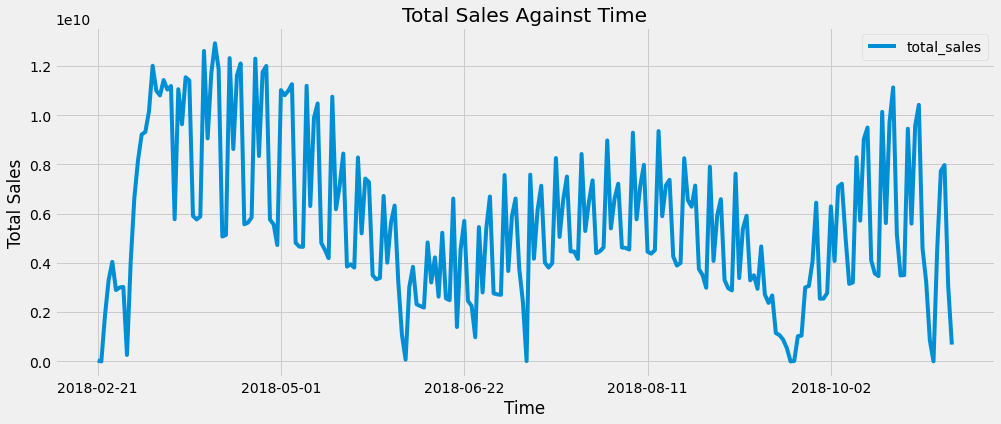

In [15]:
# Plot the total sales against time using the DataFrame df
df.plot(figsize=(15, 6))

# Set the title of the plot
plt.title(f'Total Sales Against Time')

# Set the label for the x-axis
plt.xlabel('Time')

# Set the label for the y-axis
plt.ylabel("Total Sales")

# Display the plot
plt.show()


# Check Original Stationarity <a class="anchor" id="0.6"></a>

In [16]:
def check_stationarity(df, target):
    # Retrieve the time series data from the DataFrame
    timeseries = df[target]
    
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    
    # Create a Series to store the test results
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    # Print the test statistic and p-value
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    # Print the critical values
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

# Call the check_stationarity function with the DataFrame df and the target column 'total_sales'
check_stationarity(df, 'total_sales')


The test statistic: -2.252906
p-value: 0.187607
Critical Values:
1%: -3.461
5%: -2.875
10%: -2.574


# Differencing <a class="anchor" id="0.7"></a>

In [17]:
def differencing(df, date, value, order=1):
    d = df
    
    # Set date format and set the date column as the index
    d[date] = pd.to_datetime(d[date], errors='coerce')
    d = d.set_index(date)
    
    print(f"order = {order}")
    if order == 1:
        # Calculate xt - 1
        d['xt_minus_1'] = d[value].shift(periods=1)

        # Calculate first-order differencing (RD)
        d['target_order_RD'] = d[value] - d['xt_minus_1']
    
    elif order == 2:
        # Calculate xt - 1
        d['xt_minus_1'] = d[value].shift(periods=1)
        
        # Calculate first-order differencing (RD)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        
        # Calculate first-order differencing of first-order differencing (RD)
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        
        # Calculate second-order differencing (RD)
        d['target_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        
    elif order == 3:
        # Calculate xt - 1
        d['xt_minus_1'] = d[value].shift(periods=1)
        
        # Calculate first-order differencing (RD)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        
        # Calculate first-order differencing of first-order differencing (RD)
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        
        # Calculate second-order differencing (RD)
        d['second_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        
        # Calculate second-order differencing of second-order differencing (RD)
        d['second_order_RD_minus_1'] = d['second_order_RD'].shift(periods=1)
        
        # Calculate third-order differencing (RD)
        d['target_order_RD'] = d['second_order_RD'] - d['second_order_RD_minus_1']
        
    elif order == 4:
        # Calculate xt - 1
        d['xt_minus_1'] = d[value].shift(periods=1)
        
        # Calculate first-order differencing (RD)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        
        # Calculate first-order differencing of first-order differencing (RD)
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        
        # Calculate second-order differencing (RD)
        d['second_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        
        # Calculate second-order differencing of second-order differencing (RD)
        d['second_order_RD_minus_1'] = d['second_order_RD'].shift(periods=1)
        
        # Calculate third-order differencing (RD)
        d['third_order_RD'] = d['second_order_RD'] - d['second_order_RD_minus_1']
        
        # Calculate third-order differencing of third-order differencing (RD)
        d['third_order_RD_minus_1'] = d['third_order_RD'].shift(periods=1)
        
        # Calculate fourth-order differencing (RD)
        d['forth_order_RD'] = d['third_order_RD'] - d['third_order_RD_minus_1']
                 
        # Calculate third-order differencing of third-order differencing (RD)
        d['third_order_RD_minus_1'] = d['third_order_RD'].shift(periods=1)
        
        # Calculate fourth-order differencing (RD)
        d['forth_order_RD'] = d['third_order_RD'] - d['third_order_RD_minus_1']
        
        # Calculate fourth-order differencing of fourth-order differencing (RD)
        d['forth_order_RD_minus_1'] = d['forth_order_RD'].shift(periods=1)
        
        # Calculate target order differencing (RD)
        d['target_order_RD'] = d['forth_order_RD'] - d['forth_order_RD_minus_1']
    
    elif order == 5:
        # Calculate xt - 1
        d['xt_minus_1'] = d[value].shift(periods=1)
        
        # Calculate first-order differencing (RD)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        
        # Calculate first-order differencing of first-order differencing (RD)
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        
        # Calculate second-order differencing (RD)
        d['second_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        
        # Calculate second-order differencing of second-order differencing (RD)
        d['second_order_RD_minus_1'] = d['second_order_RD'].shift(periods=1)
        
        # Calculate third-order differencing (RD)
        d['third_order_RD'] = d['second_order_RD'] - d['second_order_RD_minus_1']
        
        # Calculate third-order differencing of third-order differencing (RD)
        d['third_order_RD_minus_1'] = d['third_order_RD'].shift(periods=1)
        
        # Calculate fourth-order differencing (RD)
        d['forth_order_RD'] = d['third_order_RD'] - d['third_order_RD_minus_1']
        
        # Calculate fourth-order differencing of fourth-order differencing (RD)
        d['forth_order_RD_minus_1'] = d['forth_order_RD'].shift(periods=1)
        
        # Calculate fifth-order differencing (RD)
        d['fifth_order_RD'] = d['forth_order_RD'] - d['forth_order_RD_minus_1']
        
        # Calculate fifth-order differencing of fifth-order differencing (RD)
        d['fifth_order_RD_minus_1'] = d['fifth_order_RD'].shift(periods=1)
        
        # Calculate target order differencing (RD)
        d['target_order_RD'] = d['fifth_order_RD'] - d['fifth_order_RD_minus_1']
    
    else:
        raise Exception("Order should be <= 5")
    
    # Plot the target order differencing (RD)
    d[['target_order_RD']].plot(figsize=(15, 6))
    plt.title(f'Total Sales After Differencing with Order {order} Against Time')
    plt.xlabel('Time')
    plt.ylabel("Total Sales After Differencing")
    plt.show()

    return d


In [18]:
df['total_sales_log'] = np.log(df.total_sales)
df.head()

,total_sales,total_sales_log
date,,
2018-02-21,32030000,17.282184
2018-02-23,180000,12.100712
2018-03-14,1870938994,21.349706
2018-03-15,3309334994,21.920013
2018-03-16,4043241998,22.120313


order = 1


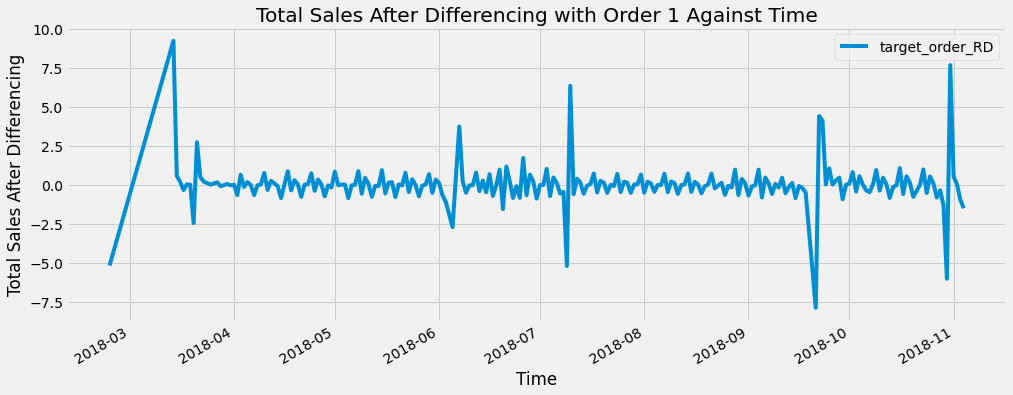

,total_sales,total_sales_log,xt_minus_1,target_order_RD
date,,,,
2018-02-21,32030000,17.282184,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471
2018-03-14,1870938994,21.349706,12.100712,9.248994
2018-03-15,3309334994,21.920013,21.349706,0.570307
2018-03-16,4043241998,22.120313,21.920013,0.200300
...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450
2018-11-01,7733829998,22.768870,22.232509,0.536361
2018-11-02,7975330000,22.799619,22.768870,0.030749


order = 2


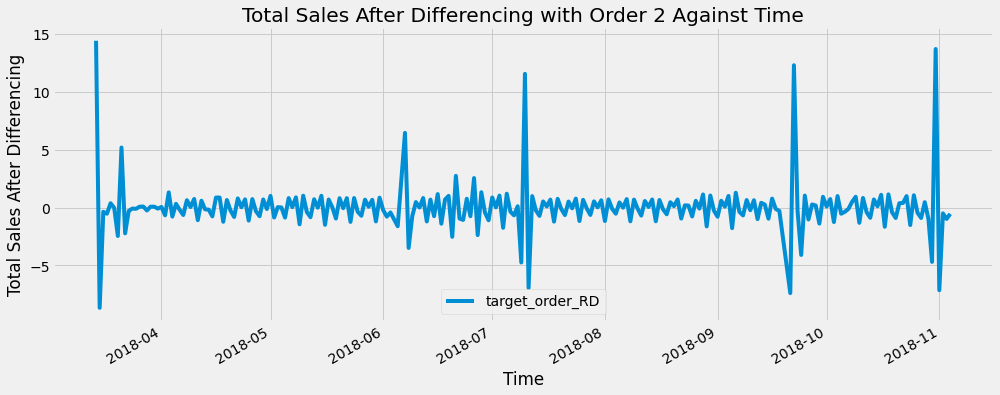

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,target_order_RD
date,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007
...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612


order = 3


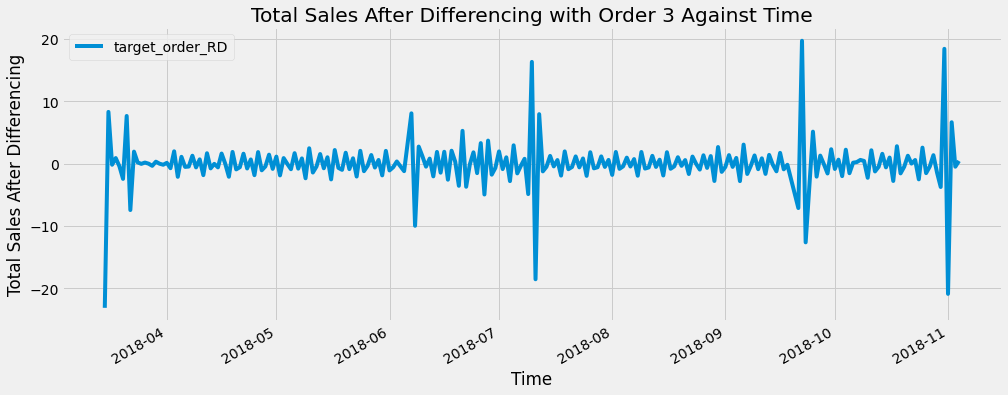

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,second_order_RD,second_order_RD_minus_1,target_order_RD
date,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680
...,...,...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207,-4.704098,18.422305
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090,13.718207,-20.871297
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612,-7.153090,6.647478


order = 4


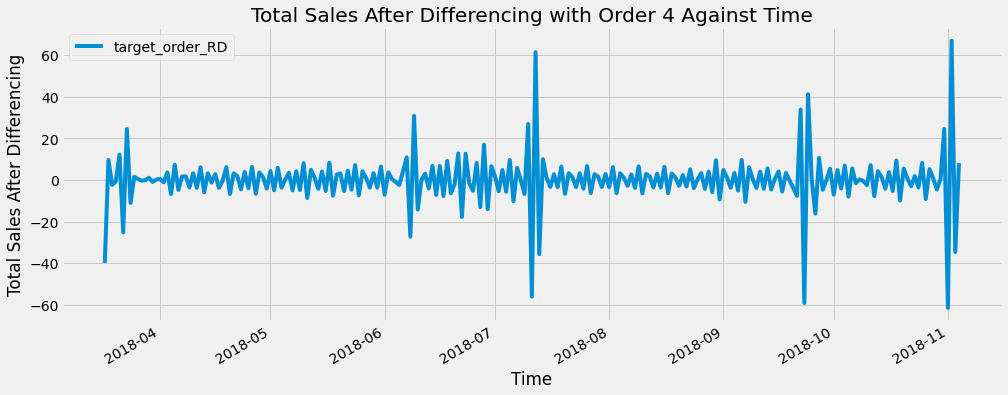

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,second_order_RD,second_order_RD_minus_1,third_order_RD,third_order_RD_minus_1,forth_order_RD,forth_order_RD_minus_1,target_order_RD
date,,,,,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153,NaN,NaN,NaN,NaN
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680,-23.109153,31.417833,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207,-4.704098,18.422305,-3.732175,22.154480,-2.295197,24.449677
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090,13.718207,-20.871297,18.422305,-39.293602,22.154480,-61.448082
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612,-7.153090,6.647478,-20.871297,27.518775,-39.293602,66.812376


order = 5


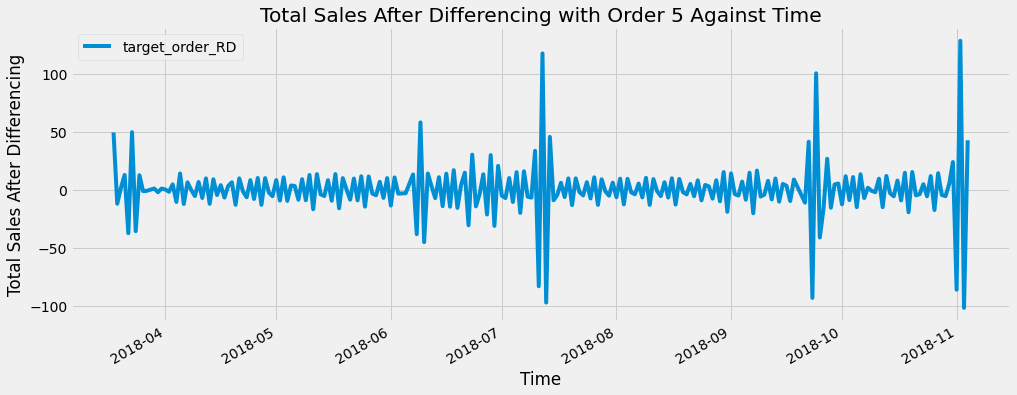

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,second_order_RD,second_order_RD_minus_1,third_order_RD,third_order_RD_minus_1,forth_order_RD,forth_order_RD_minus_1,fifth_order_RD,fifth_order_RD_minus_1,target_order_RD
date,,,,,,,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680,-23.109153,31.417833,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207,-4.704098,18.422305,-3.732175,22.154480,-2.295197,24.449677,0.509939,23.939738
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090,13.718207,-20.871297,18.422305,-39.293602,22.154480,-61.448082,24.449677,-85.897759
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612,-7.153090,6.647478,-20.871297,27.518775,-39.293602,66.812376,-61.448082,128.260458


check stationarity of order 1
The test statistic: -11.317884
p-value: 0.000000
Critical Values:
1%: -3.459
5%: -2.874
10%: -2.574


In [19]:
df_temp = df.reset_index()

df2_T = differencing(df_temp, 'date', 'total_sales_log', order=1)
display(df2_T)

TEMP = differencing(df_temp, 'date', 'total_sales_log', order=2)
display(TEMP)

TEMP = differencing(df_temp, 'date', 'total_sales_log', order=3)
display(TEMP)

TEMP = differencing(df_temp, 'date', 'total_sales_log', order=4)
display(TEMP)

TEMP = differencing(df_temp, 'date', 'total_sales_log', order=5)
display(TEMP)

df2 = df2_T.dropna()
print("check stationarity of order 1")
check_stationarity(df2, 'target_order_RD')

# Autocorrelation and Partial Autocorrelation <a class="anchor" id="0.8"></a>

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


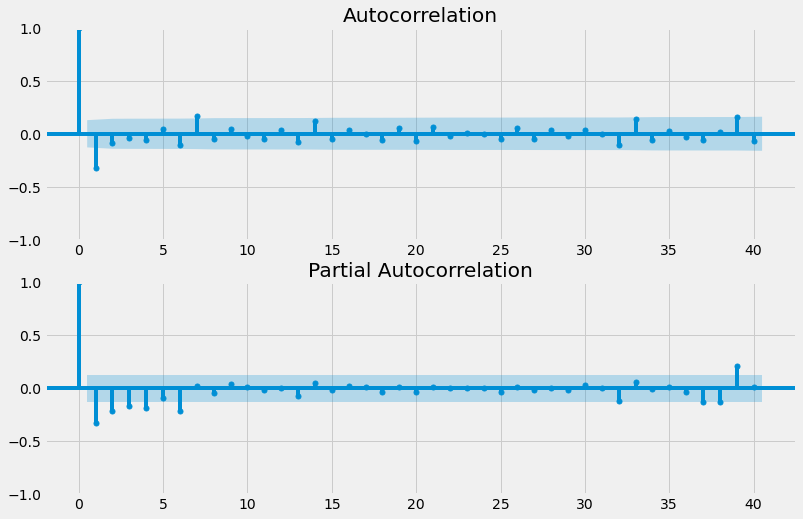

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2.target_order_RD,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2.target_order_RD,lags=40,ax=ax2)

In [21]:
def simple_moving_average(arr, window_size, weights=None):
    i = 0
    len_array = len(arr)+1
    answer = [None] * len_array
    computation = [None] * len_array
    row = window_size
    
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider every window of size window_size
    while i < len(arr) - window_size + 1:

        # Calculate the average of the current window
        if weights is None:
            array_values = arr[i:i+window_size]
            window_average = round(np.sum(array_values) / window_size, 3)
            answer[row] = window_average
            computation[row] = f"sum({array_values}) / ({window_size}) = {window_average}"
        else:
            array_values = arr[i:i+window_size]
            array_values_multiplied = [a * b for a, b in zip(array_values, weights)]
            array_values_multiplied = [round(num, 4) for num in array_values_multiplied]
            window_average = round(np.sum(array_values_multiplied), 4)
            answer[row] = window_average
            computation[row] = f"sum({array_values_multiplied}) = {window_average}"
        
        # Store the average of the current window in the moving_averages list
        moving_averages.append(window_average)
        
        # Shift the window to the right by one position
        i += 1
        row += 1

    # Append None to the array to align it with the moving averages
    arr.append(None)
    
    # Create a DataFrame to store the actual values, forecasted values, and computations
    d = {'Actual': arr, f'Forecasted, w={window_size}': answer, 'Computation': computation}
    df_result = pd.DataFrame(d)
    
    # Print the forecasted result
    print(f"Forecasted result: {answer[-1]}")
    
    # Create a DataFrame for metrics calculation, dropping NaN values
    df_metric = df_result.dropna()
    y_actual = df_metric['Actual'].values.tolist()
    y_predicted = df_metric[f'Forecasted, w={window_size}'].values.tolist()
    
    return df_result

In [22]:
index = df.index.tolist()
index.append('2018-11-05')

# Convert the 'total_sales' column to a flattened list
arr = df['total_sales'].values.flatten().tolist()

# Specify the window size
window_size = 2

# Calculate the moving averages using the simple_moving_average function
result_ma = simple_moving_average(arr, window_size, weights=None)

# Set the index of the result_ma DataFrame
result_ma.index = index

# Drop any rows with NaN values
result_ma = result_ma.dropna()

# Display the resulting DataFrame
result_ma


Forecasted result: 1874382500.0


,Actual,"Forecasted, w=2",Computation
2018-03-14,1.870939e+09,1.610500e+07,"sum([32030000, 180000]) / (2) = 16105000.0"
2018-03-15,3.309335e+09,9.355595e+08,"sum([180000, 1870938994]) / (2) = 935559497.0"
2018-03-16,4.043242e+09,2.590137e+09,"sum([1870938994, 3309334994]) / (2) = 25901369..."
2018-03-17,2.895673e+09,3.676288e+09,"sum([3309334994, 4043241998]) / (2) = 36762884..."
2018-03-18,3.002792e+09,3.469457e+09,"sum([4043241998, 2895672996]) / (2) = 34694574..."
...,...,...,...
2018-10-31,4.523308e+09,4.307655e+08,"sum([859461000, 2070000]) / (2) = 430765500.0"
2018-11-01,7.733830e+09,2.262689e+09,"sum([2070000, 4523308000]) / (2) = 2262689000.0"
2018-11-02,7.975330e+09,6.128569e+09,"sum([4523308000, 7733829998]) / (2) = 61285689..."
2018-11-03,3.065780e+09,7.854580e+09,"sum([7733829998, 7975330000]) / (2) = 78545799..."


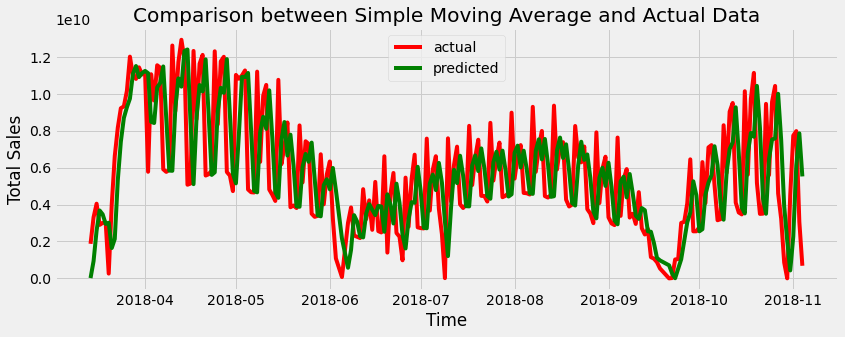

In [23]:
temp = result_ma.reset_index()

# Convert the 'index' column to datetime format
temp['index'] = pd.to_datetime(temp["index"], errors='coerce')

# Set the index of the DataFrame to 'index' column
result_ma = temp.set_index('index')

# Set the size of the plot
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)

# Set the title and labels for the plot
plt.title(f'Comparison between Simple Moving Average and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

# Plot the actual and predicted values
plt.plot(result_ma.Actual, label='actual', color='r')
plt.plot(result_ma['Forecasted, w=2'], label='predicted', color='g')

# Display the legend
plt.legend()


In [24]:
method_list = []
granular_method_list = []
rmse_list = []
mse_list = []
mae_list = []
r2_list = []

d = {
    'Method': method_list,
    'Granular Method': granular_method_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

def get_metric(df, results, method, granular_method):
    # Compute metrics
    mse = mean_squared_error(actual, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predict)
    r2 = r2_score(actual, predict)

    # Append metrics to respective lists
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    # Create a DataFrame from the lists
    result = pd.DataFrame(d)
    return result

# Define the actual and predicted values for the metric calculation
actual = result_ma['Actual'].tail(30)
predict = result_ma['Forecasted, w=2'].tail(30)
method = 'Timeseries'
granular_method = 'Simple Moving Average'

# Calculate and retrieve the metrics
get_metric(actual, predict, method, granular_method)

,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578


In [25]:
index = df.index.tolist()
index.append('2018-11-05')

arr = df['total_sales'].values.flatten().tolist()
window_size = 2
weights = [0.2, 0.3, 0.5]
result_ma_weighted = simple_moving_average(arr, window_size, weights=weights)
result_ma_weighted.index = index
result_ma_weighted = result_ma_weighted.dropna()
result_ma_weighted


Forecasted result: 818051500.0


,Actual,"Forecasted, w=2",Computation
2018-03-14,1.870939e+09,6.460000e+06,"sum([6406000.0, 54000.0]) = 6460000.0"
2018-03-15,3.309335e+09,5.613177e+08,"sum([36000.0, 561281698.2]) = 561317698.2"
2018-03-16,4.043242e+09,1.366988e+09,"sum([374187798.8, 992800498.2]) = 1366988297.0"
2018-03-17,2.895673e+09,1.874840e+09,"sum([661866998.8, 1212972599.4]) = 1874839598.2"
2018-03-18,3.002792e+09,1.677350e+09,"sum([808648399.6, 868701898.8]) = 1677350298.4"
...,...,...,...
2018-10-31,4.523308e+09,1.725132e+08,"sum([171892200.0, 621000.0]) = 172513200.0"
2018-11-01,7.733830e+09,1.357406e+09,"sum([414000.0, 1356992400.0]) = 1357406400.0"
2018-11-02,7.975330e+09,3.224811e+09,"sum([904661600.0, 2320148999.4]) = 3224810599.4"
2018-11-03,3.065780e+09,3.939365e+09,"sum([1546765999.6, 2392599000.0]) = 3939364999.6"


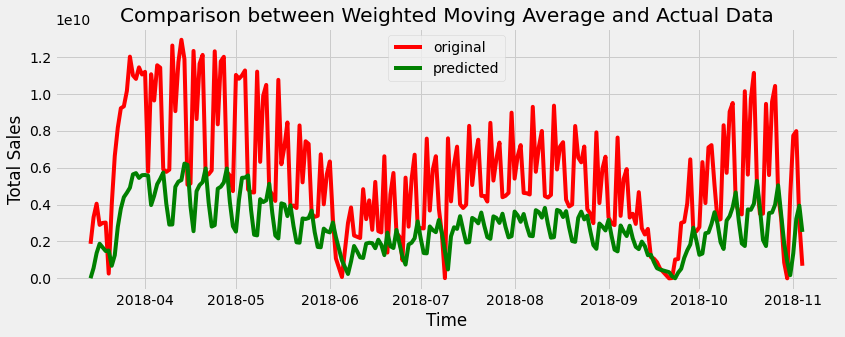

In [26]:
temp = result_ma_weighted.reset_index()
temp['index'] = pd.to_datetime(temp["index"], errors='coerce')
result_ma_weighted = temp.set_index('index')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between Weighted Moving Average and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(result_ma_weighted.Actual, label='original', color='r')
plt.plot(result_ma_weighted['Forecasted, w=2'], label='predicted', color='g')
plt.legend()

In [27]:
def get_metric(actual, predict, method, granular_method):
    # Compute metrics
    mse = mean_squared_error(actual, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predict)
    r2 = r2_score(actual, predict)

    # Append lists
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    # Create a DataFrame with the metrics
    result = pd.DataFrame({
        'Method': method_list,
        'Granular Method': granular_method_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'MAE': mae_list,
        'R2': r2_list
    })

    return result
# 'rmse_list', 'mae_list', 'r2_list' defined before this code

actual = result_ma_weighted['Actual'].tail(30)
predict = result_ma_weighted['Forecasted, w=2'].tail(30)
method = 'Timeseries'
granular_method = 'Weighted Moving Average'
result = get_metric(actual, predict, method, granular_method)
result

,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210


# Find Best ARIMA <a class="anchor" id="0.9"></a>

In [28]:
auto_arima_fit = pm.auto_arima(df.total_sales, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                               seasonal=False, trace=True, error_action='ignore', suppress_warnings=True,
                               stepwise=True)


/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10750.810, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10815.783, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10788.369, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10756.223, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10813.785, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10752.217, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10739.277, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10749.278, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10751.820, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10744.388, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10757.360, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10732.491, Time=0.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10712.348, Time=0.83 sec
 ARIMA(3,1,1)(0,0,0)[0] i

In [29]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")  # specify to ignore warning messages

mod = ARIMA(df.total_sales, order=(3, 1, 2))
results = mod.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                  234
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5349.041
Date:                Thu, 11 May 2023   AIC                          10710.082
Time:                        00:52:58   BIC                          10730.788
Sample:                             0   HQIC                         10718.431
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8801      0.053     16.629      0.000       0.776       0.984
ar.L2         -0.3482      0.070     -4.950      0.000      -0.486      -0.210
ar.L3         -0.3198      0.061     -5.201      0.0

# Residual Plot <a class="anchor" id="0.11"></a>

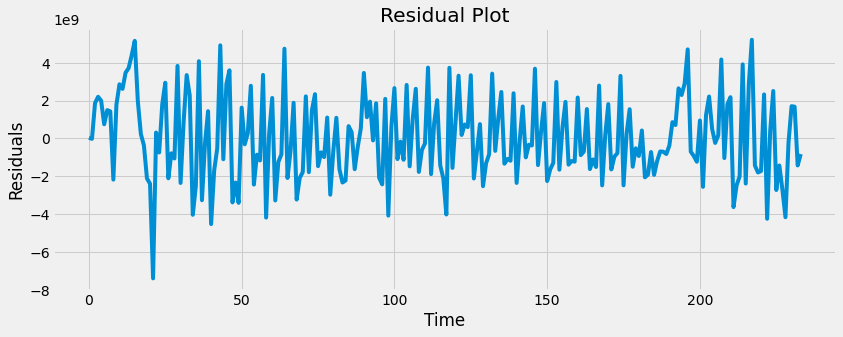

In [30]:
# Create a DataFrame to store the residuals
residuals = pd.DataFrame(results.resid)

# Reset the index and convert the 'date' column to datetime format
temp = residuals.reset_index()
temp['date'] = pd.to_datetime(temp['date'], errors='coerce')
residuals = temp.set_index('date')

# Configure the plot
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot the residuals
plt.plot(residuals.values)

Text(0, 0.5, 'Total Sales')

<Figure size 432x288 with 0 Axes>

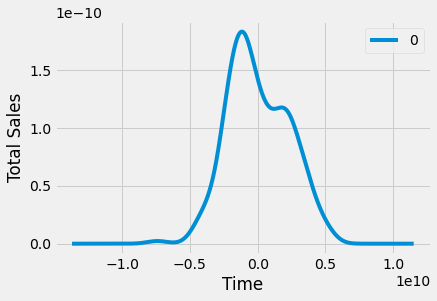

In [31]:
# Configure the plot
fig = matplotlib.pyplot.gcf()
ax = residuals.plot(kind='kde')
ax.set_xlabel('Time')
ax.set_ylabel('Total Sales')

# The plot displays the kernel density estimation (KDE) of the residuals over time


In [32]:
residuals.describe()

,0
count,2.340000e+02
mean,3.771118e+07
std,2.212655e+09
min,-7.389388e+09
25%,-1.543907e+09
50%,-3.487167e+08
75%,1.845270e+09
max,5.209873e+09


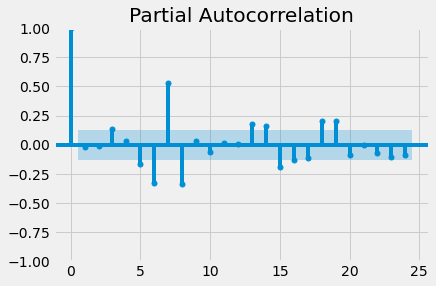

In [33]:
#Plotting partial autocorrelation factors
plot_pacf(residuals)
print()

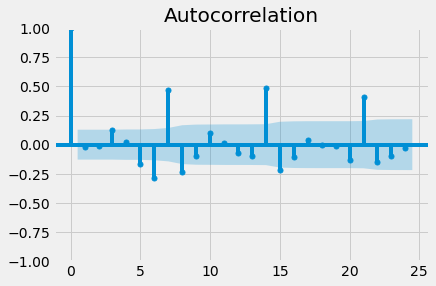

In [34]:
#plotting autocorrelation factors
plot_acf(residuals)
print()

# Prediction Plot <a class="anchor" id="0.12"></a>

In [35]:
def coerce_time(df, attribute):
    # Reset the index of the DataFrame
    temp = df.reset_index()
    
    # Convert the specified attribute to datetime
    temp[attribute] = pd.to_datetime(temp[attribute], errors='coerce')
    
    # Set the attribute as the index of the DataFrame
    df = temp.set_index(attribute)
    
    return df


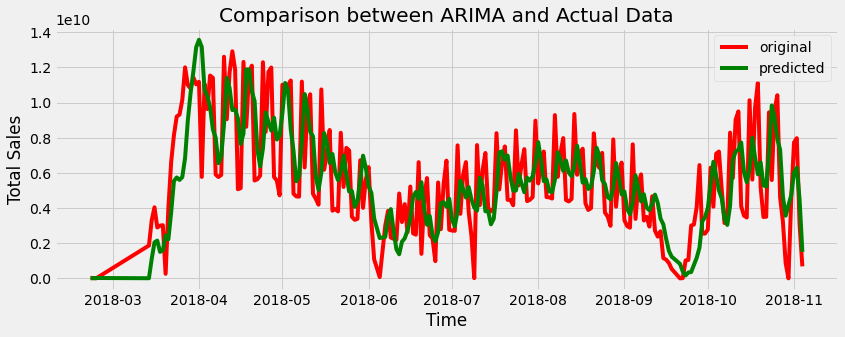

In [36]:
index_list = df[:234].index.tolist()

# Generate predictions from the ARIMA model
prediction = results.predict(0, 233)

# Set the index of the prediction series
prediction = prediction.set_axis(index_list)

# Convert the prediction series to a DataFrame and coerce the index to datetime
prediction = prediction.to_frame()
prediction = coerce_time(prediction, 'index')

# Coerce the 'date' column in the original DataFrame to datetime
df = coerce_time(df, 'date')

# Plot the original and predicted data
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between ARIMA and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df.total_sales[:234], label='original', color='r')
plt.plot(prediction, label='predicted', color='g')

plt.legend()

In [37]:
def get_forecast_values(df, N=30):
    # Get the last date from the DataFrame
    last_date = df.reset_index().at[len(df) - 1, 'date']
    print(f"last date: {last_date}")
    
    # Compute the forecast start date by adding one day to the last date
    for_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)
    print(f"start forecast date: {for_date}")

    # Generate the forecast values using the ARIMA model's forecast method
    forecast = results.forecast(steps=N)
    
    # Create an index range for the forecast values starting from the forecast date
    index = pd.date_range(start=for_date, periods=N)
    
    # Create a DataFrame to store the forecast values with the index
    df_forecast = pd.DataFrame({'forecast': forecast.values}, index=index)
    
    return df_forecast

# Get the forecast values for the next 30 periods
df_forecast = get_forecast_values(df, N=30)

# Keep only the 'total_sales' column in the original DataFrame
df = df[['total_sales']]

# Convert the 'date' column of the original DataFrame to datetime
aa = df.reset_index()
aa['date'] = pd.to_datetime(aa['date'], errors='coerce')
print(aa.info())

# Set the 'date' column as the index in the DataFrame
aa.set_index('date', inplace=True)
print(aa.info())

# Convert the index of the forecast DataFrame to datetime
xx = df_forecast.reset_index()
print(xx.info())

# Rename the 'index' column to 'date' in the forecast DataFrame
xx.rename(columns={'index': 'date'}, inplace=True)

# Set the 'date' column as the index in the forecast DataFrame
xx.set_index('date', inplace=True)
print(xx.info())


last date: 2018-11-04 00:00:00
start forecast date: 2018-11-05 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         234 non-null    datetime64[ns]
 1   total_sales  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2018-02-21 to 2018-11-04
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_sales  234 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     30 non-null     datetime64[ns]
 1   forecast  30 non-null     float64  

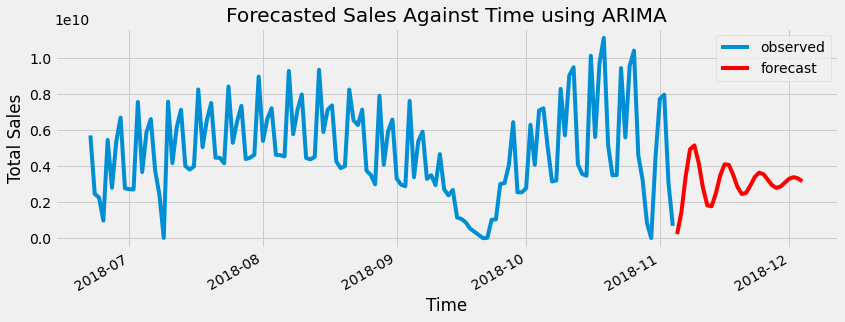

In [38]:
df_forecast = xx
df = aa

def show_forecast_plot(df, df_forecast, method):
    # Get the confidence intervals from the forecast DataFrame
    ci = df_forecast.values
    
    # Plot the observed data
    ax = df[100:].total_sales.plot(label='observed', figsize=(20, 15))
    
    # Plot the forecasted values
    df_forecast.plot(ax=ax, label='Forecast', color='r')
    
    # Fill the area between the upper and lower confidence intervals
    ax.fill_between(df_forecast.index, ci[:, -1], ci[:, 0], color='b', alpha=.25)
    
    # Set the labels for the x-axis and y-axis
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 4.5)
    
    # Add a legend to the plot
    plt.legend()
    
    # Set the title of the plot
    plt.title(f'Forecasted Sales Against Time using {method}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    
    # Display the plot
    return plt.show()

# Call the show_forecast_plot function to display the forecast plot
show_forecast_plot(df, df_forecast, 'ARIMA')


In [39]:
def get_metric(df, results, method, granular_method):
    # Get the last 30 actual values from the 'total_sales' column of the DataFrame
    actual = df['total_sales'].tail(30) 
    
    # Generate predictions for the last 30 periods using the ARIMA model
    predict = results.predict().tail(30)

    # Compute the evaluation metrics
    mse = mean_squared_error(actual, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predict)
    r2 = r2_score(actual, predict)

    # Append the metrics to the corresponding lists
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    # Create a DataFrame to store the results
    result = pd.DataFrame(d)
    
    return result

method = 'Timeseries'
granular_method = 'ARIMA'

# Call the get_metric function to compute and store the evaluation metrics
get_metric(df, results, method, granular_method)


,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219


# SARIMAX <a class="anchor" id="0.13"></a>

In [40]:
Sarimax_model = auto_arima(df.total_sales,start_P=1,start_q=1, max_p=3,max_q=3, m=12,seasonal=True,d=None,D=1,
                       trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10445.753, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10359.928, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10444.193, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10395.175, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10354.999, Time=0.88 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=10429.498, Time=0.88 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=10353.304, Time=1.41 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=10361.082, Time=0.40 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

In [41]:
model = SARIMAX(df.total_sales, order=(3, 0, 3), seasonal_order=(2, 1, 0, 12),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41593D+08    |proj g|=  5.39762D+09


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     49      2     0     0   1.804D+09   3.574D+07
  F =   35743115.565984085     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


                                      SARIMAX Results                                      
Dep. Variable:                         total_sales   No. Observations:                  234
Model:             SARIMAX(3, 0, 3)x(2, 1, [], 12)   Log Likelihood         -8363889042.440
Date:                             Thu, 11 May 2023   AIC                    16727778102.881
Time:                                     01:09:51   BIC                    16727778132.338
Sample:                                          0   HQIC                   16727778114.807
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1876   1.06e-05   1.12e+05      0.000       1.188       1.188
ar.L2         -1.3112   1.0

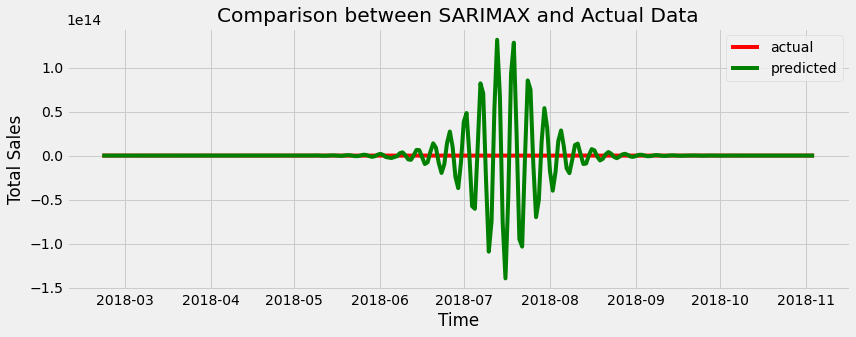

In [42]:
index_list = df[:234].index.tolist()

# Generate predictions using the SARIMAX model
prediction = results.predict(0, 233)

# Set the index of the predictions to match the original data
prediction = prediction.set_axis(index_list)

# Convert the predictions to a DataFrame and coerce the index to datetime
prediction = prediction.to_frame()
prediction = coerce_time(prediction, 'index')

# Coerce the index of the original data to datetime
df = coerce_time(df, 'date')

# Plotting the actual and predicted data
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between SARIMAX and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df.total_sales[:234], label='actual', color='r')
plt.plot(prediction, label='predicted', color='g')
plt.legend()


In [43]:
df_forecast = get_forecast_values(df, N=30)

# Select the 'total_sales' column from the DataFrame
df = df[['total_sales']]

# Reset the index of the original data and convert the 'date' column to datetime
aa = df.reset_index()
aa['date'] = pd.to_datetime(aa['date'], errors='coerce')
print(aa.info())

# Set the 'date' column as the index of the DataFrame
aa.set_index('date', inplace=True)
print(aa.info())

# Reset the index of the forecast DataFrame and convert the 'index' column to datetime
xx = df_forecast.reset_index()
print(xx.info())

# Rename the 'index' column to 'date' and set it as the index of the DataFrame
xx.rename(columns={'index': 'date'}, inplace=True)
xx.set_index('date', inplace=True)
print(xx.info())


last date: 2018-11-04 00:00:00
start forecast date: 2018-11-05 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         234 non-null    datetime64[ns]
 1   total_sales  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2018-02-21 to 2018-11-04
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_sales  234 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     30 non-null     datetime64[ns]
 1   forecast  30 non-null     float64  

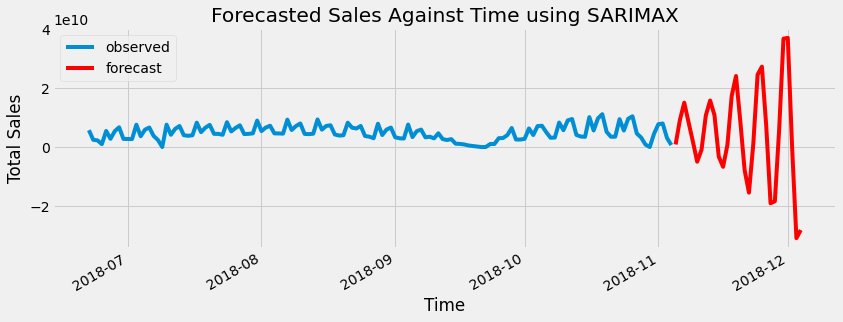

In [44]:
df_forecast = xx
df = aa

def show_forecast_plot(df, df_forecast, method):
    ci = df_forecast.values
    ax = df[100:].total_sales.plot(label='observed', figsize=(20, 15))
    df_forecast.plot(ax=ax, label='Forecast', color='r')
    ax.fill_between(df_forecast.index, ci[:, -1], ci[:, 0], color='b', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 4.5)
    plt.legend()

    plt.title(f'Forecasted Sales Against Time using {method}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    return plt.show()

show_forecast_plot(df, df_forecast, 'SARIMAX')


In [45]:
method = 'Timeseries'  # Set the general forecasting method
granular_method = 'SARIMAX'  # Set the specific forecasting method

# Call the get_metric function to compute the metrics
result = get_metric(df, results, method, granular_method)


# Machine Learning <a class="anchor" id="0.14"></a>

In [46]:
def get_data():
    df2 = df.copy()

    # Create lagged features using shift()
    df2['shift_1'] = df2['total_sales'].shift(periods=1)
    df2['shift_2'] = df2['total_sales'].shift(periods=2)
    df2['shift_3'] = df2['total_sales'].shift(periods=3)
    df2['shift_4'] = df2['total_sales'].shift(periods=4)
    df2['shift_5'] = df2['total_sales'].shift(periods=5)

    # Drop rows with NaN values
    df2 = df2.dropna()
    return df2

def get_forcast_date(df):
    forcast_date = df.index[-1] + pd.DateOffset(days=1)
    return forcast_date

def append_row(df):
    new_row = np.flip(np.append(df.total_sales[-5:].values, np.nan))
    forcast_date = get_forcast_date(df)

    # Add new row with specified index name
    df.loc[forcast_date] = new_row
    return df, forcast_date

def train_test_split(df2, n_test):
    # Split data into training and test sets
    x_train = df2.iloc[:-n_test, 1:]
    y_train = df2.iloc[:-n_test, :1]
    x_test = df2.iloc[-n_test:, 1:]
    y_test = df2.iloc[-n_test:, :1]
    return x_train, y_train, x_test, y_test

def model_train(x_train, y_train, model, model_value):
    if model == 'XGB':
        print("Using XGB model")
        model = model_value  # XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=0)
    else:
        print("Using RFR model")
        model = model_value  # RandomForestRegressor(random_state=0)

    # Fit the model
    model = model.fit(x_train, y_train)

    # Predict on the training data
    x_train_pred = model.predict(x_train)
    print("Model Fit Already")
    return model, x_train_pred

def model_test_predict(model_fit, x_test):
    # Predict on the test data
    yhat = model_fit.predict(x_test.values)
    return yhat

def get_metrics_ml(model_fit, x_test, y_test, model):
    # Compute metrics for evaluation
    yhat = model_test_predict(model_fit, x_test)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, yhat)
    r2 = r2_score(y_test, yhat)

    method = 'Machine Learning'
    granular_method = model

    # Append metrics to the lists
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    result = pd.DataFrame(d)
    return result

def model_forecast(model_fit, df):
    # Generate forecast using the trained model
    new_row = np.flip(df.total_sales[-5:].values)
    yhat = model_fit.predict([new_row.tolist()])
    df, forcast_date = append_row(df)
    df.at[forcast_date, 'total_sales'] = yhat
    return df

def model_forecast_n(n, model_fit, df):
    # Generate multipledef model_forecast_n(n, model_fit, df):
   for nx in range(n):
        df = model_forecast(model_fit, df)
        return df


In [47]:
# Get the preprocessed data
df2 = get_data()

# Get the forecast date for the new prediction
forcast_date = get_forcast_date(df2)
print(forcast_date)

# Perform train-test split
x_train, y_train, x_test, y_test = train_test_split(df2, 30)

# Train and evaluate RandomForestRegressor with different n_estimators values
model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=100))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=100)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=200))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=200)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=300)')

# Train and evaluate XGBRegressor with different n_estimators values
model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGB(n_estimators=100)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGB(n_estimators=200)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGB(n_estimators=300)')

# Display the results
result

2018-11-05 00:00:00
Using RFR model
Model Fit Already
Using RFR model
Model Fit Already
Using RFR model
Model Fit Already
Using XGB model
Model Fit Already
Using XGB model
Model Fit Already
Using XGB model
Model Fit Already


,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219
3,Timeseries,SARIMAX,1.059172e+20,1.029161e+10,7.143514e+09,-9.955959
4,Machine Learning,RFR(n_estimators=100),7.663778e+18,2.768353e+09,2.388568e+09,0.207267
5,Machine Learning,RFR(n_estimators=200),7.417655e+18,2.723537e+09,2.329582e+09,0.232726
6,Machine Learning,RFR(n_estimators=300),7.409955e+18,2.722123e+09,2.329854e+09,0.233522
7,Machine Learning,XGB(n_estimators=100),8.220709e+18,2.867178e+09,2.273592e+09,0.149659
8,Machine Learning,XGB(n_estimators=200),8.219685e+18,2.866999e+09,2.273558e+09,0.149765
9,Machine Learning,XGB(n_estimators=300),8.219713e+18,2.867004e+09,2.273564e+09,0.149762


In [48]:
# Get the preprocessed data
df2 = get_data()

# Get the forecast date for the new prediction
forcast_date = get_forcast_date(df2)
print(forcast_date)

# Perform train-test split
x_train, y_train, x_test, y_test = train_test_split(df2, 30)

# Train the RandomForestRegressor with n_estimators=300
model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))

# Forecast the future values using the trained model
df2 = model_forecast_n(30, model_fit, df2)

# Display the updated DataFrame with the forecasted values
df2


2018-11-05 00:00:00
Using RFR model
Model Fit Already


,total_sales,shift_1,shift_2,shift_3,shift_4,shift_5
date,,,,,,
2018-03-17,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05,3.203000e+07
2018-03-18,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05
2018-03-19,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09
2018-03-20,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09
2018-03-21,4.008355e+09,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09
...,...,...,...,...,...,...
2018-11-01,7.733830e+09,4.523308e+09,2.070000e+06,8.594610e+08,3.232349e+09,4.599490e+09
2018-11-02,7.975330e+09,7.733830e+09,4.523308e+09,2.070000e+06,8.594610e+08,3.232349e+09
2018-11-03,3.065780e+09,7.975330e+09,7.733830e+09,4.523308e+09,2.070000e+06,8.594610e+08


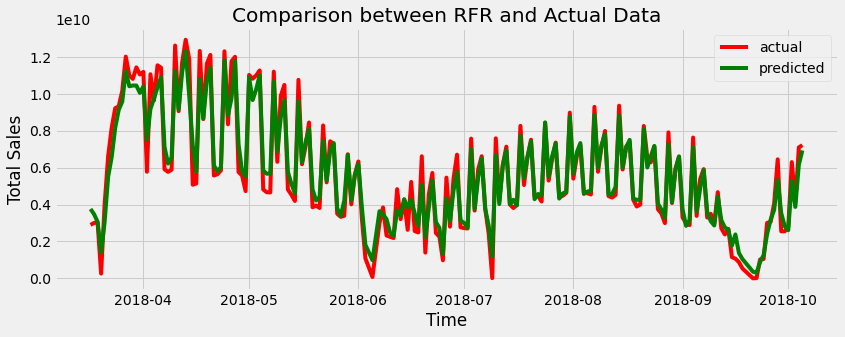

In [49]:
# Get the actual data
actual = get_data().iloc[:-30:]

# Prepare the index list for the prediction DataFrame
index_list = actual.index.tolist()

# Create a DataFrame for the predictions
prediction = x_train_pred_RFR
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

# Set up the plot
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between RFR and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

# Plot the actual and predicted values
plt.plot(actual.total_sales, label='actual', color='r')
plt.plot(prediction, label='predicted', color='g')
plt.legend()

# Show the plot
plt.show()


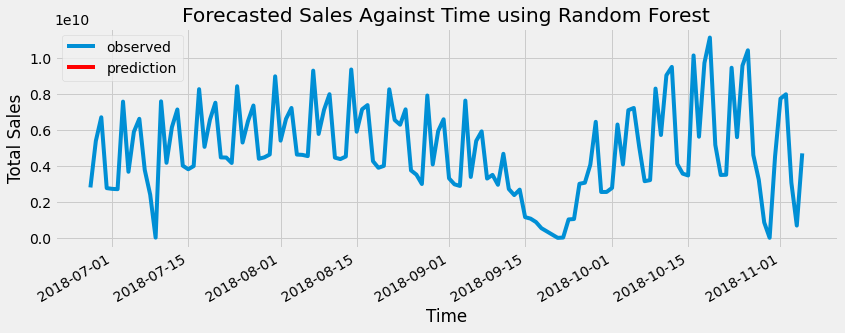

In [50]:
# Separate the actual and forecasted dataframes
df_actual = df2[['total_sales']].loc[:forcast_date]
df_forecast = df2[['total_sales']].loc[forcast_date:]

# Rename the column in the forecast dataframe to 'prediction'
df_forecast = df_forecast.rename(columns={'total_sales': 'prediction'})

# Show the forecast plot
show_forecast_plot(df_actual, df_forecast, 'Random Forest')


# To Forecast using XGB

In [51]:
# Obtain the data and split it for forecasting with XGB
df2 = get_data()
forcast_date = get_forcast_date(df2)
print(forcast_date)
x_train, y_train, x_test, y_test = train_test_split(df2, 30)

# Train the XGB model
model_fit, x_train_pred_XGB = model_train(x_train.values, y_train.values, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=0))

# Generate forecasts using the XGB model
df2 = model_forecast_n(30, model_fit, df2)
df2


2018-11-05 00:00:00
Using XGB model
Model Fit Already


,total_sales,shift_1,shift_2,shift_3,shift_4,shift_5
date,,,,,,
2018-03-17,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05,3.203000e+07
2018-03-18,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05
2018-03-19,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09
2018-03-20,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09
2018-03-21,4.008355e+09,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09
...,...,...,...,...,...,...
2018-11-01,7.733830e+09,4.523308e+09,2.070000e+06,8.594610e+08,3.232349e+09,4.599490e+09
2018-11-02,7.975330e+09,7.733830e+09,4.523308e+09,2.070000e+06,8.594610e+08,3.232349e+09
2018-11-03,3.065780e+09,7.975330e+09,7.733830e+09,4.523308e+09,2.070000e+06,8.594610e+08


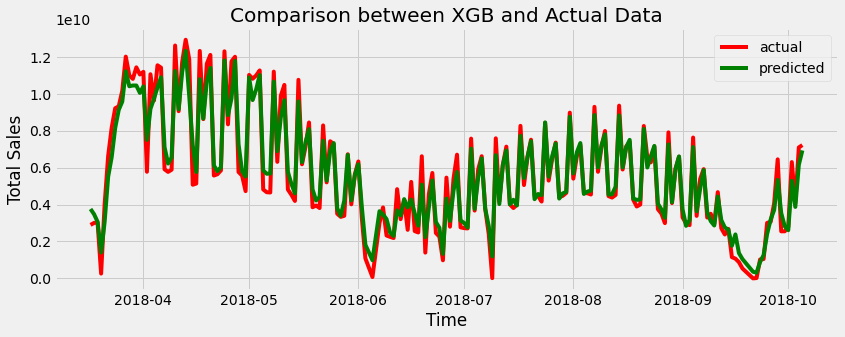

In [52]:
# Get the actual data for comparison
actual = get_data().iloc[:-30: ]
index_list = actual.index.tolist()

# Create a dataframe for the predictions
prediction = x_train_pred_RFR
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

# Create the plot
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between XGB and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

# Plot the actual and predicted values
plt.plot(actual.total_sales, label='actual', color='r')
plt.plot(prediction, label='predicted', color='g')
plt.legend()


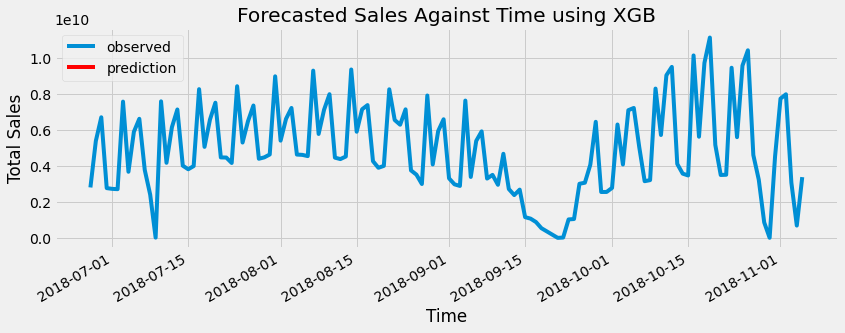

In [53]:
# Select the actual data for plotting
df = df2[['total_sales']].loc[:forcast_date]

# Select the forecasted data for plotting
df_forecast = df2[['total_sales']].loc[forcast_date:]
df_forecast = df_forecast.rename(columns={'total_sales': 'prediction'})

# Call the function to show the forecast plot
show_forecast_plot(df, df_forecast, 'XGB')


In [54]:
result['AIC'] = 199 * np.log(result['MSE']) + 2 * 100
result['BIC'] = 199 * np.log(result['MSE']) + 100 * np.log(199)

# RFR 200
result.at[5,'AIC'] = 199 * np.log(result.at[5,'MSE']) + 2 * 200
result.at[5,'BIC'] = 199 * np.log(result.at[5,'MSE']) + 200 * np.log(199)

# RFR 300
result.at[6,'AIC'] = 199 * np.log(result.at[6,'MSE']) + 2 * 300
result.at[6,'BIC'] = 199 * np.log(result.at[6,'MSE']) + 300 * np.log(199)

# XGB 200
result.at[8,'AIC'] = 199 * np.log(result.at[8,'MSE']) + 2 * 200
result.at[8,'BIC'] = 199 * np.log(result.at[8,'MSE']) + 200 * np.log(199)

# XGB 300
result.at[9,'AIC'] = 199 * np.log(result.at[9,'MSE']) + 2 * 300
result.at[9,'BIC'] = 199 * np.log(result.at[9,'MSE']) + 300 * np.log(199)

# ARIMA
result.at[2,'AIC'] =10710.082; result.at[2,'BIC'] =10730.788 ; 

# sarimax
result.at[3,'AIC'] =9014.453; result.at[3,'BIC'] =9043.910 ; 

# MA
result.at[0,'AIC'] =234 * np.log(result.at[0,'MSE']) + 2 * 2; 
result.at[0,'BIC'] =234 * np.log(result.at[0,'MSE']) + 2 * np.log(234) ; 

# Weighted
result.at[1,'AIC'] =234 * np.log(result.at[1,'MSE']) + 2 * 2; 
result.at[1,'BIC'] =234 * np.log(result.at[1,'MSE']) + 2 * np.log(234) ; 

result

,Method,Granular Method,MSE,RMSE,MAE,R2,AIC,BIC
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578,10310.030431,10316.941073
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210,10367.150625,10374.061267
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219,10710.082000,10730.788000
3,Timeseries,SARIMAX,1.059172e+20,1.029161e+10,7.143514e+09,-9.955959,9014.453000,9043.910000
4,Machine Learning,RFR(n_estimators=100),7.663778e+18,2.768353e+09,2.388568e+09,0.207267,8853.124321,9182.454803
5,Machine Learning,RFR(n_estimators=200),7.417655e+18,2.723537e+09,2.329582e+09,0.232726,9046.628533,9705.289498
6,Machine Learning,RFR(n_estimators=300),7.409955e+18,2.722123e+09,2.329854e+09,0.233522,9246.421854,10234.413302
7,Machine Learning,XGB(n_estimators=100),8.220709e+18,2.867178e+09,2.273592e+09,0.149659,8867.084443,9196.414926
8,Machine Learning,XGB(n_estimators=200),8.219685e+18,2.866999e+09,2.273558e+09,0.149765,9067.059652,9725.720617
9,Machine Learning,XGB(n_estimators=300),8.219713e+18,2.867004e+09,2.273564e+09,0.149762,9267.060317,10255.051764


# Concluding Remarks <a class="anchor" id="0.15"></a>

In the process of model selection, it is observed that the moving average models (MA(2) and Weighted MA(2)) in this study yield negative R^2 values. R^2 values can range from -∞ to 1, and negative values indicate that the fitted model performs worse than a horizontal line in a nonlinear function. Consequently, these models are not considered for further model selection.

Among the evaluated models, ARIMA(3, 1, 2) demonstrates the lowest MSE, RMSE, and MAE, as well as the highest R^2. This indicates that the ARIMA model effectively captures the underlying patterns in the total sales data. However, it does not yield the best AIC and BIC metrics, suggesting that it may not strike the optimal balance between model fit and complexity.

On the other hand, the Random Forest Regressor (RFR) with n_estimators=100 achieves the best trade-off between model fit and complexity. Although its average R^2 value is the fourth highest among the selected models, R^2 is considered the most informative performance metric in this research and widely used in scientific analyses. Additionally, previous studies have suggested selecting models with low AIC and high R^2.

In conclusion, if an entity prioritizes model performance, ARIMA(3, 1, 2) can be chosen as the best model. However, if efficiency in utilizing training data without overfitting is a primary concern, RFR with n_estimators=100 is recommended. Organizations can select the best model based on their specific needs to forecast future sales accurately. This can lead to various benefits, such as allocating marketing resources effectively, planning for growth, and optimizing screening times.